# FT_SOMMELIER

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
red_wine_df = pd.read_csv("/nfs/2018/t/tholzheu/42_program/ft_sommelier/resources/winequality-red.csv", sep=';')
white_wine_df = pd.read_csv("/nfs/2018/t/tholzheu/42_program/ft_sommelier/resources/winequality-white.csv", sep=';')

In [3]:
red_wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
white_wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [122]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    fig, axmat = plt.subplots(12, 12, figsize=(10, 10))
    for axrow in axmat:
        for ax in axrow:
            ax.set_xticks([])
            ax.set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.text(1, 1, 'hello')
    #plt.scatter(red_wine_df['volatile acidity'][red_wine_df['quality'] > good_threshold], 
     #           red_wine_df['fixed acidity'][red_wine_df['quality'] > good_threshold], c='c')
    #plt.scatter(red_wine_df['volatile acidity'][red_wine_df['quality'] < bad_threshold], 
     #           red_wine_df['fixed acidity'][red_wine_df['quality'] < bad_threshold], c='k')
    plt.show()
    

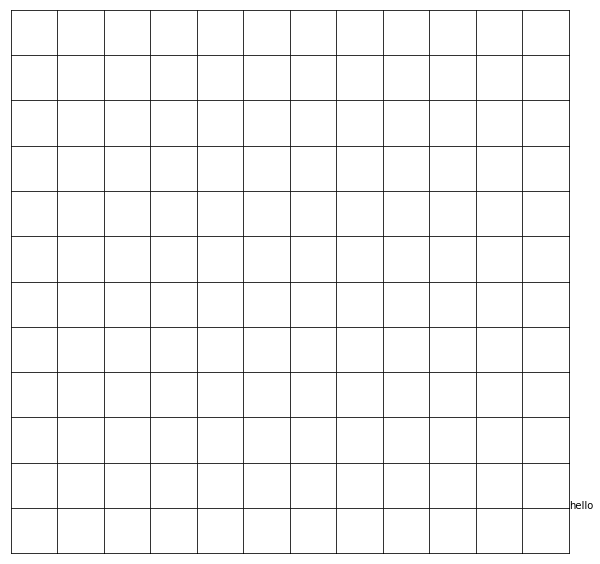

In [123]:
plot_scatter_matrix(red_wine_df, 6, 5)